# we are going to create an LTSM model to predict XRP values. Giving that I invsted and lost big with this currency XD

### We start by adding the libraries 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import tensorflow as tf

### Then we simply read the data file and check if there was any missing value

In [2]:
df = pd.read_csv("XRP-USD.csv")
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2125 entries, 0 to 2124
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2125 non-null   object 
 1   Open       2125 non-null   float64
 2   High       2125 non-null   float64
 3   Low        2125 non-null   float64
 4   Close      2125 non-null   float64
 5   Adj Close  2125 non-null   float64
 6   Volume     2125 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 116.3+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,0.217911,0.221791,0.214866,0.217488,0.217488,147916992
1,2017-11-10,0.218256,0.219068,0.205260,0.206483,0.206483,141032992
2,2017-11-11,0.205948,0.214456,0.205459,0.210430,0.210430,134503008
3,2017-11-12,0.210214,0.210214,0.195389,0.197339,0.197339,251175008
4,2017-11-13,0.197472,0.204081,0.197456,0.203442,0.203442,132567000
...,...,...,...,...,...,...,...
2120,2023-08-30,0.540045,0.540165,0.523152,0.528194,0.528194,967541032
2121,2023-08-31,0.528195,0.528462,0.505080,0.510799,0.510799,1074749312
2122,2023-09-01,0.510788,0.511623,0.488601,0.498075,0.498075,1097204087
2123,2023-09-02,0.498060,0.502110,0.495362,0.499091,0.499091,661651382


### We are going to need only 2 cols for the models Date and Close because that what we are intrested in 

In [3]:
df=df[['Date','Close']]

In [4]:
df

,Date,Close
0,2017-11-09,0.217488
1,2017-11-10,0.206483
2,2017-11-11,0.210430
3,2017-11-12,0.197339
4,2017-11-13,0.203442
...,...,...
2120,2023-08-30,0.528194
2121,2023-08-31,0.510799
2122,2023-09-01,0.498075
2123,2023-09-02,0.499091


### After we've done with the Data Frame we need to convert the Date  values from Str to Datetime 

In [5]:
import datetime

In [6]:
def str_to_datetime(s):
    split=s.split('-')
    year,month,day = int (split[0]),int (split[1]),int (split[2])
    return datetime.datetime (year=year , month=month , day= day )
daterime_obj = str_to_datetime('1999-08-09')
daterime_obj

datetime.datetime(1999, 8, 9, 0, 0)

### Now we apply the function 

In [7]:
df["Date"]=df["Date"].apply(str_to_datetime)

C:\Users\maxia\AppData\Local\Temp\ipykernel_1220\1874889523.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Date"]=df["Date"].apply(str_to_datetime)


In [8]:
df["Date"]

0      2017-11-09
1      2017-11-10
2      2017-11-11
3      2017-11-12
4      2017-11-13
          ...    
2120   2023-08-30
2121   2023-08-31
2122   2023-09-01
2123   2023-09-02
2124   2023-09-03
Name: Date, Length: 2125, dtype: datetime64[ns]

### Now let's make the Date as the index col

In [9]:
df.index=df.pop('Date')

### let us see the closed dates

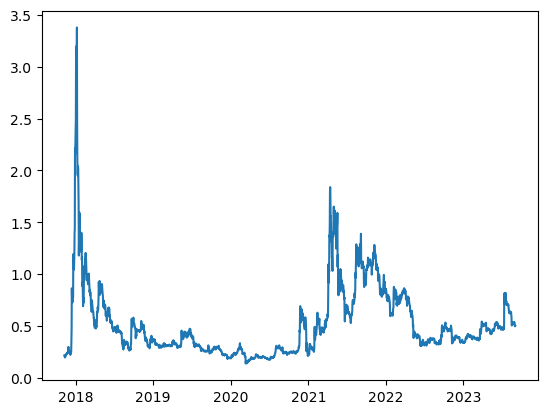

In [10]:
plt.plot(df.index,df['Close'])

### Now I got this big helpful function online. What it does in summary is take the last three days values and put them in every row as a sequence and so we can use them as featur inputs to get predections. We start from the date 11-11-2018 Note : It will include a lot of data up to date which probably will make the model in danger of overfitting

In [11]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date
  
  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)
    
    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))
    
    if last_time:
      break
    
    target_date = next_date

    if target_date == last_date:
      last_time = True
    
  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates
  
  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]
  
  ret_df['Target'] = Y

  return ret_df

# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '2018-11-11', 
                                '2023-09-02', 
                                n=3)
windowed_df[1:]

,Target Date,Target-3,Target-2,Target-1,Target
1,2018-11-12,0.500668,0.506698,0.505913,0.517165
2,2018-11-13,0.506698,0.505913,0.517165,0.510112
3,2018-11-14,0.505913,0.517165,0.510112,0.474372
4,2018-11-15,0.517165,0.510112,0.474372,0.481708
5,2018-11-16,0.510112,0.474372,0.481708,0.471609
...,...,...,...,...,...
1752,2023-08-29,0.523470,0.523844,0.523248,0.540065
1753,2023-08-30,0.523844,0.523248,0.540065,0.528194
1754,2023-08-31,0.523248,0.540065,0.528194,0.510799
1755,2023-09-01,0.540065,0.528194,0.510799,0.498075


### Now we create three Variables of Date , X and Y 

In [12]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]
#here we mean the middle values of the previous 3 days which are X
  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1757,), (1757, 3, 1), (1757,))

### Now we split our data to 80% training and 10% Validation and 10%testing

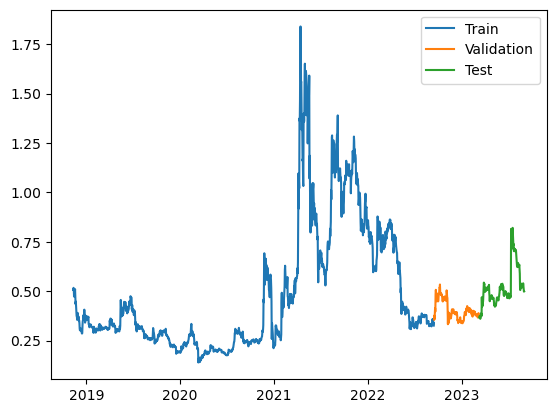

In [13]:
q_80 = int(len(dates)*0.8)
q_90 = int(len(dates)* 0.9)
dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

### Now we build our model with Keras Sequential with value 64 LTSM 

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30)

Epoch 1/30
44/44 [==============================] - 3s 15ms/step - loss: 0.1124 - mean_absolute_error: 0.2373 - val_loss: 0.0026 - val_mean_absolute_error: 0.0468
Epoch 2/30
44/44 [==============================] - 0s 4ms/step - loss: 0.0076 - mean_absolute_error: 0.0613 - val_loss: 6.0580e-04 - val_mean_absolute_error: 0.0183
Epoch 3/30
44/44 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0283 - val_loss: 4.2965e-04 - val_mean_absolute_error: 0.0137
Epoch 4/30
44/44 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0282 - val_loss: 4.1508e-04 - val_mean_absolute_error: 0.0133
Epoch 5/30
44/44 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0279 - val_loss: 3.9626e-04 - val_mean_absolute_error: 0.0132
Epoch 6/30
44/44 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0287 - val_loss: 3.7352e-04 - val_mean_absolute_error: 0.0122
Epoch 7

### Now we check how our model is doing with Train, Validate and test

44/44 [==============================] - 1s 2ms/step


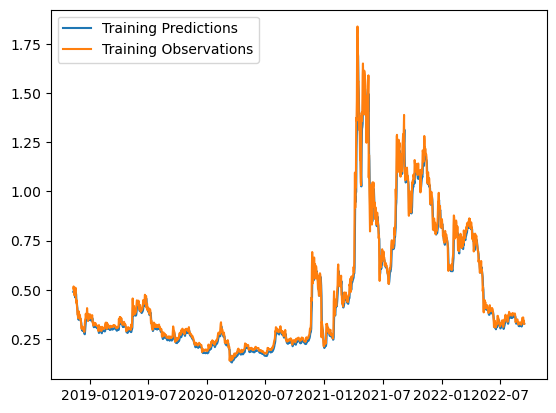

In [15]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 [==============================] - 0s 3ms/step


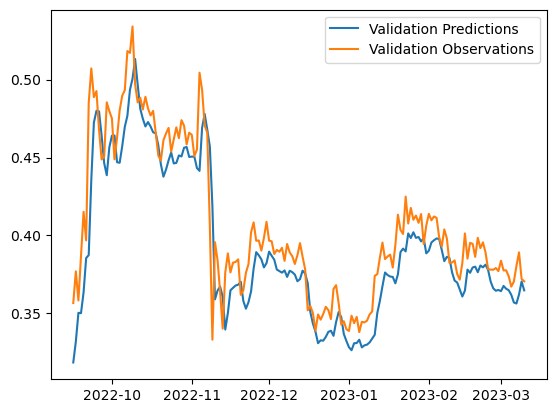

In [16]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

6/6 [==============================] - 0s 2ms/step


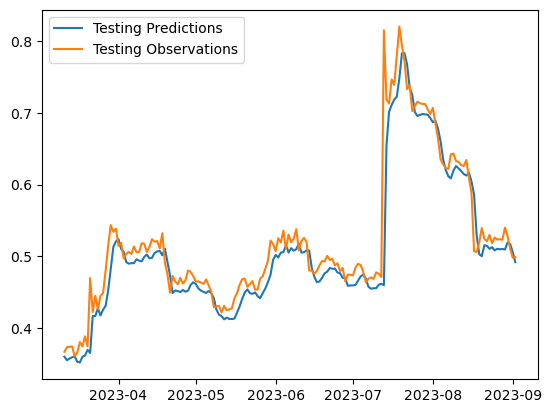

In [17]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

### Well that was intersting I thouth using a lot of data will overfit the model but actually the model did pretty well on the validation and testing data. with what seems a relativly high accuracy for a simple model.

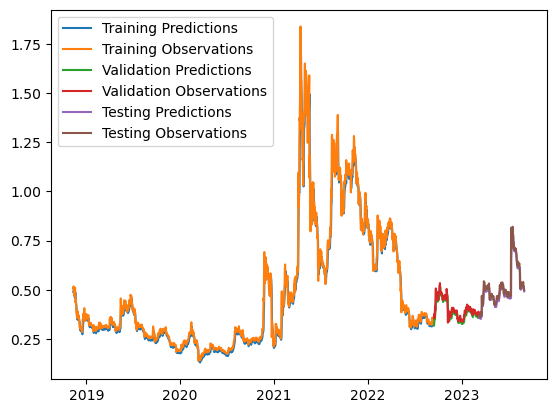

In [18]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])